In [1]:
import riversound, glob, obspy, matplotlib, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
## run this code if you're using ipython and it doesn't show plot windows
# %matplotlib qt 
## FFT works best when data length is a power of 2, so use this function to help determine window size.
def next_power_2(x):
    return int(2**np.ceil(np.log2(x)))

def interp_times(t_out, t, q):
    t_out = np.array([x.timestamp() for x in t_out])
    t = np.array([x.timestamp() for x in t])
    return np.interp(t_out, t, q)

def reformat(l): # turn list l into a numpy array
    lengths = np.array([len(i) for i in l])
    normal_length = lengths[lengths > 0][0]
    if any((lengths != 0) & (lengths != normal_length)):
        raise ValueError('nonzero lengths of elements of l must all be the same')
    for i in np.where(lengths == 0)[0]:
        l[i] = np.zeros(normal_length)
    return np.array(l)
    
## set year, frequency bands, and site, add path_audible and path_infrasound
year = '22'
site = 'FB3'
season = 'Spring'
infra_freqs_low = [5,20]
infra_freqs_high = [20,40]
infra_power_band_limit = [[] for i in range(len(infra_freqs_low))]
aud_freqs_low = [50]
aud_freqs_high = [500]
aud_power_band_limit = [[] for i in range(len(aud_freqs_low))]

path = '/home/scott/bender/gradschool/data/' + site + '_all/'
station_name = ' ' + site + ' 20' + year
path_infrasound = path + 'infra'
path_audible = path + 'aud' 
day1 = obspy.UTCDateTime('20' + year + '-02-15')
day2 = obspy.UTCDateTime('20' + year + '-05-17')
n_days = int(np.round((day2 - day1)/86400)) # length of study period in days

# if site == 'CON1*' or 'FB*':
#     aud_files  = sorted(glob.glob(path_audible + '*.WAV'))
## Enter the times of day (UTC) to read data from.
start_hour = 3 + 6 # 6 is time zone difference vs UTC
end_hour = 4 + 6
plot_times = np.zeros(n_days, dtype = object)

# For 2-D data like these, it's a little easier to initialize as an empty list and then convert to
# np.array. Reason is because audiomoth data can have multiple sample rates, and because of that
## we don't know the number of points in the spectrum until after we start reading files.
times_infrasound = []
meanspec_list_infrasound = [] 
medspec_list_infrasound = []
power_infrasound = []
times_audible = []
meanspec_list_audible = []
medspec_list_audible = []
power_audible = []

In [2]:
## Loop through all the days, read the data, calculate spectra, and save to outputs
for i in range(n_days):
    current_day = day1 + i*86400
    t1 = current_day.replace(hour = start_hour)
    t2 = current_day.replace(hour = end_hour)
    
    tr_infrasound, tr_audible = riversound.read_infrasound_audible(t1, t2, path_infrasound, path_audible) #infrasound_sensor_response_file = '/home/scott/anaconda3/envs/gem/lib/python3.9/site-packages/gemlog/data/response/sensor/RESP.XX.IS000..BDF.GEMV0.26.0_0023', infrasound_logger_response_file = '/home/scott/anaconda3/envs/gem/lib/python3.9/site-packages/gemlog/data/response/datalogger/RESP.XX.GM002..HHZ.GEMINFRAV1.0.100'
    nfft_infrasound = next_power_2(10 / tr_infrasound.stats.delta) # >10-sec windows for freq resolution finer than 0.1 Hz
    print([i, current_day, tr_infrasound, tr_audible])
        
    nfft_audible = next_power_2(0.1 / tr_audible.stats.delta) # >0.1-sec windows for freq res finer than 10 Hz
    plot_times[i] = current_day.datetime
        #    times_infrasound.append((tr_infrasound.stats.starttime + 0.5*(tr_infrasound.stats.endtime - tr_infrasound.stats.starttime)).datetime)
    times_infrasound.append(t1.datetime)
    times_audible.append(t1.datetime)

    ## infrasound
    # try: # check whether the data can be processed (i.e., make sure it isn't missing)
    #     tr_infrasound.filter('highpass', freq = 1, zerophase = True)
    #     spec_info = riversound.spectrum(tr_infrasound, nfft = nfft_infrasound, kurtosis_threshold = 0.5)
    # except: # do nothing if there's an error in the above code block
    #     medspec_list_infrasound.append([])
    #     meanspec_list_infrasound.append([])
    #     power_infrasound.append(np.nan)
    # else: # append the results to the output lists if there's no error
    #     freqs_infrasound_all = spec_info['freqs']
    #     medspec_list_infrasound.append(spec_info['median'])
    #     meanspec_list_infrasound.append(spec_info['mean'])
    #     specgram_all = spec_info['specgram']
    #     power_infrasound.append(np.sum(spec_info['median']) * np.diff(spec_info['freqs'])[0]) # integral spec * df
    #     for k in [0,1]: # change to 0,1,2... for more n bands defined in freqs low and high
    #             indices_infra = (freqs_infrasound_all > infra_freqs_low[k]) & (freqs_infrasound_all < infra_freqs_high[k])
    #             infra_power_band_limit[k].append(np.sum(spec_info['median'][indices_infra]) * np.diff(spec_info['freqs'])[0])
    # ## audible
    try:
        spec_info = riversound.spectrum(tr_audible, nfft = nfft_audible, kurtosis_threshold= 0.5)
        assert len(spec_info['mean']) > 0 # raises an exception if an empty result is returned
    except:
        medspec_list_audible.append([])
        meanspec_list_audible.append([])
        power_audible.append(np.nan)
    else:
        freqs_audible_all = spec_info['freqs']
        medspec_list_audible.append(spec_info['median'])
        meanspec_list_audible.append(spec_info['mean'])
        specgram_all = spec_info['specgram']
        power_audible.append(np.sum(spec_info['median']) * np.diff(spec_info['freqs'])[0])
        for k in [0]: # audible
                indices_aud = (freqs_audible_all > aud_freqs_low[k]) & (freqs_audible_all < aud_freqs_high[k])
                aud_power_band_limit[k].append(np.sum(spec_info['median'][indices_aud]) * np.diff(spec_info['freqs'])[0])

No infrasound files found in path /home/scott/bender/gradschool/data/FB3_all/infra
Reading file /home/scott/bender/gradschool/data/FB3_all/aud/20220215_090000.WAV
No infrasound files found for these times
[0, UTCDateTime(2022, 2, 15, 0, 0), <obspy.core.trace.Trace object at 0x7f6fee65d9d0>, <obspy.core.trace.Trace object at 0x7f6fee65dbe0>]
No infrasound files found in path /home/scott/bender/gradschool/data/FB3_all/infra
Reading file /home/scott/bender/gradschool/data/FB3_all/aud/20220216_090000.WAV
No infrasound files found for these times
[1, UTCDateTime(2022, 2, 16, 0, 0), <obspy.core.trace.Trace object at 0x7f6fee6a0d90>, <obspy.core.trace.Trace object at 0x7f6fee6a0fa0>]
No infrasound files found in path /home/scott/bender/gradschool/data/FB3_all/infra
Reading file /home/scott/bender/gradschool/data/FB3_all/aud/20220217_090000.WAV
No infrasound files found for these times
[2, UTCDateTime(2022, 2, 17, 0, 0), <obspy.core.trace.Trace object at 0x7f6fee694eb0>, <obspy.core.trace.Trac

https://waterservices.usgs.gov/nwis/iv/?sites=13206000&parameterCd=00060&startDT=2022-02-14T09:00:00&endDT=2022-05-17T09:00:00&siteStatus=all&format=rdb


/tmp/ipykernel_100757/1329445241.py:84: RuntimeWarning: divide by zero encountered in log10
  riversound.image(np.log10(medspec_audible), times_audible, freqs_audible, crosshairs = False, log_y = True)


(1.52, 4.0)

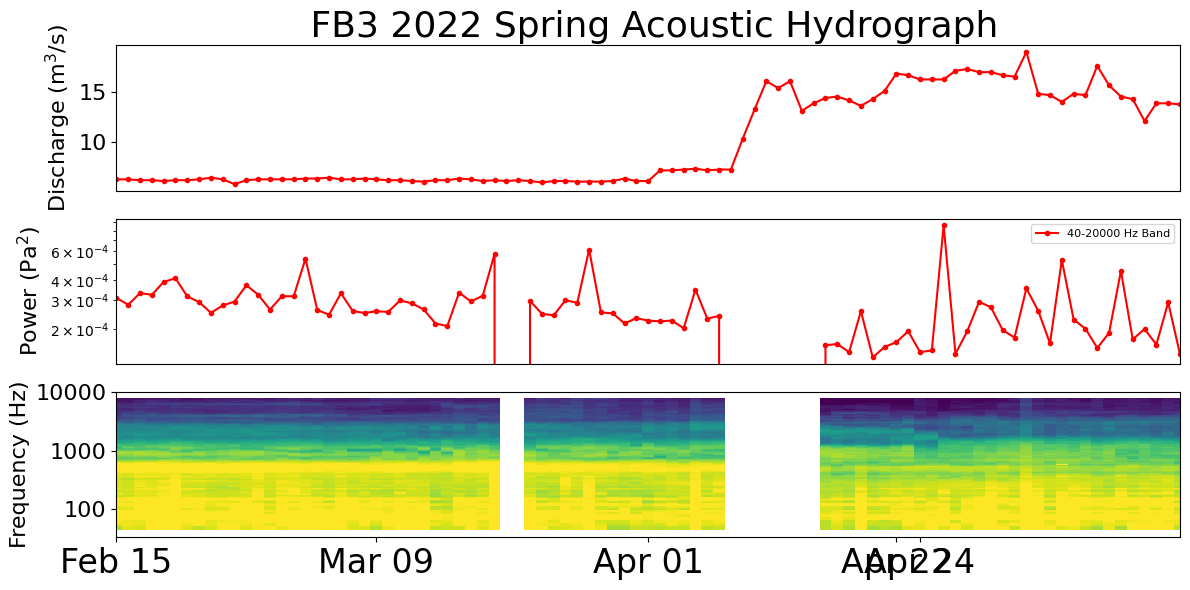

In [3]:
## reformat result lists from the loop into numpy arrays that are easy to plot
# w = (freqs_infrasound_all < 40) & (freqs_infrasound_all > 5)
# freqs_infrasound = freqs_infrasound_all[w]    
# meanspec_infrasound = reformat(meanspec_list_infrasound)[:,w]
# medspec_infrasound = reformat(medspec_list_infrasound)[:,w]
# power_infrasound = medspec_infrasound.sum(1) * np.diff(freqs_infrasound)[0]

w = (freqs_audible_all < 20000) & (freqs_audible_all > 40)
freqs_audible = freqs_audible_all[w]    
meanspec_audible = reformat(meanspec_list_audible)[:,w]
medspec_audible = reformat(medspec_list_audible)[:,w]
power_audible = medspec_audible.sum(1) * np.diff(freqs_audible)[0]

xlim = [np.min(times_infrasound), np.max(times_infrasound)]
if site == 'LG':
    t, q = riversound.read_DCEW(filename = '/home/scott/bender/gradschool/data/LG_StreamHrlySummary_20' + year + '_new.csv')
elif site == 'CON1E':
    t, q = riversound.read_DCEW(filename = '/home/scott/bender/gradschool/data/C1E_StreamHrlySummary_20' + year + '_new.csv')
elif site == 'CON1W':
     t, q = riversound.read_DCEW(filename = '/home/scott/bender/gradschool/data/C1W_StreamHrlySummary_20' + year + '_new.csv')
else:
    t, q = riversound.read_discharge('glenwood', xlim[0] - datetime.timedelta(days=1), xlim[1] + datetime.timedelta(days=1)) 

 
## plot the discharge, power, and spectrogram
plt.figure(figsize = (12,6)) 
plt.subplot(3,1,1) # discharge
# plt.plot(t,q)
Q_time = interp_times(times_infrasound, t, q)
plt.plot(times_infrasound, Q_time, 'r.-')
#plt.ylim([np.min(Q_time)- 0.5*np.min(Q_time), np.max(Q_time)+ 0.5*np.max(Q_time)])
plt.xticks([], fontsize = 18)
q_ticks = [0,-1]
plt.yticks(fontsize = 16)
plt.xlim(xlim[0], xlim[1])
plt.ylabel('Discharge (m$^3$/s)', fontsize = 16)
plt.title(station_name + ' Spring Acoustic Hydrograph', fontsize = 26)

# plot labels for FB1 drone points
# indices_fb1 = [1, 7, 10, 15]
# #indices_fb1 = [4, 11, int(n_days/2)-2]
# discharge_fb1 = [Q_time[i] for i in indices_fb1]
# marker_indices = [times_audible[i] for i in indices_fb1]
# plt.scatter(marker_indices, discharge_fb1,  marker= '*', s= 200, color = 'blue')
# addition = [1.3* k for k in discharge_fb1]
# plt.plot(marker_indices[0], addition[0]+10, marker="$A$", markersize=14, color = 'black', markeredgecolor="black")
# plt.plot(marker_indices[1], addition[1]+10, marker="$B$", markersize=14, color = 'black', markeredgecolor="black")
# plt.plot(marker_indices[2], addition[2]+10, marker="$C$", markersize=14, color = 'black', markeredgecolor="black")
# plt.plot(marker_indices[3], addition[3], marker="$D$", markersize=14, color = 'black', markeredgecolor="black")

plt.subplot(3,1,2) # power
#plt.plot(times_infrasound, power_infrasound, '.-', label = '5-40 Hz Band')
#plt.plot(times_infrasound, infra_power_band_limit[0], 'b--.', label = str(infra_freqs_low[0]) + '-' + str(infra_freqs_high[0]) + ' Hz Band' )
#plt.plot(times_infrasound, infra_power_band_limit[1], 'r--.', label = str(infra_freqs_low[1]) + '-' + str(infra_freqs_high[1]) + ' Hz Band' )
#plt.plot(times_infrasound, infra_power_band_limit[2], 'k--.', label = str(infra_freqs_low[2]) + '-' + str(infra_freqs_high[2]) + ' Hz Band' )
#plt.ylim(0,0.004)
plt.semilogy(times_audible, power_audible, 'r.-', label = '40-20000 Hz Band')
#plt.semilogy(times_audible, aud_power_band_limit[0], '.-', linewidth = 2, label = str(aud_freqs_low[0]) + '-' + str(aud_freqs_high[0]) + ' Hz Band')
#for y in infra_power_band_limit:
#   plt.semilogy(times_infrasound, y, linewidth = 2, label = str(infra_freqs_low[0]) + '-' + str(infra_freqs_high[0]) + ' Hz Band')

# for y in aud_power_band_limit:

    #power_audible_band = y
    #band_fb1 = [y[i] for i in indices_fb1]
    #plt.scatter(marker_indices, band_fb1,  marker= '*', s= 100, color = 'blue')
#plt.legend(loc= (0.25, 0.65), prop={'size': 10})
plt.legend(loc= 'best', fontsize = 8)
plt.xlim(xlim[0], xlim[1])
plt.ylabel('Power (Pa$^2$)', fontsize = 16)
plt.yticks(fontsize = 16)
plt.xticks([])
plt.xticks(fontsize = 18)

# indices_fb1 = np.array([int(n_days/2)+4, int(n_days/4)+5, int(n_days*0.75), -3])
# power_fb1 = [power_audible[i] for i in indices_fb1]
# g = [times_audible[i] for i in indices_fb1]
# plt.scatter(g, power_fb1,  marker= '*', s= 100, color = 'blue')

plt.subplot(3,1,3) # spectrogram
#plt.plot(times_infrasound, riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13))
#plt.plot(times_audible, riversound.find_mean_freq(meanspec_audible, freqs_audible, 13))
#riversound.image(np.log10(medspec_infrasound), times_infrasound, freqs_infrasound, crosshairs = False, log_y = True) # aud and infra log_y must match
riversound.image(np.log10(medspec_audible), times_audible, freqs_audible, crosshairs = False, log_y = True)
plt.xlim(xlim[0], xlim[1])
plt.yticks(np.arange(5), 10**np.arange(5), fontsize = 16)
pdtimes_infrasound =  pd.to_datetime(times_infrasound)
indices1 = [0,26,57,87,118,149,170] # for full 2021 Ridenbaugh: [0,26,57,87,118,149,170]

indices_general = [0, int(n_days/2), int(n_days/4), int(n_days*0.75), -25]
#indices_fb1 = [4, 11, int(n_days/2)-2, int(n_days*0.75), -3] # for spring figure
g = pdtimes_infrasound.strftime('%b %d')
g = [g[inds] for inds in indices_general]
ticks = [pdtimes_infrasound[inds] for inds in indices_general]
plt.xticks(ticks = ticks, labels = g, fontsize = 24)
plt.yticks(fontsize = 16)
plt.ylabel('Frequency (Hz)', fontsize = 16)
plt.tight_layout()
plt.ylim(1.52,4)
#plt.hlines(y = 3, xmin = np.min(times_audible), xmax = np.max(times_audible))
#plt.savefig('June-SeptEckert2021_hydrograph')

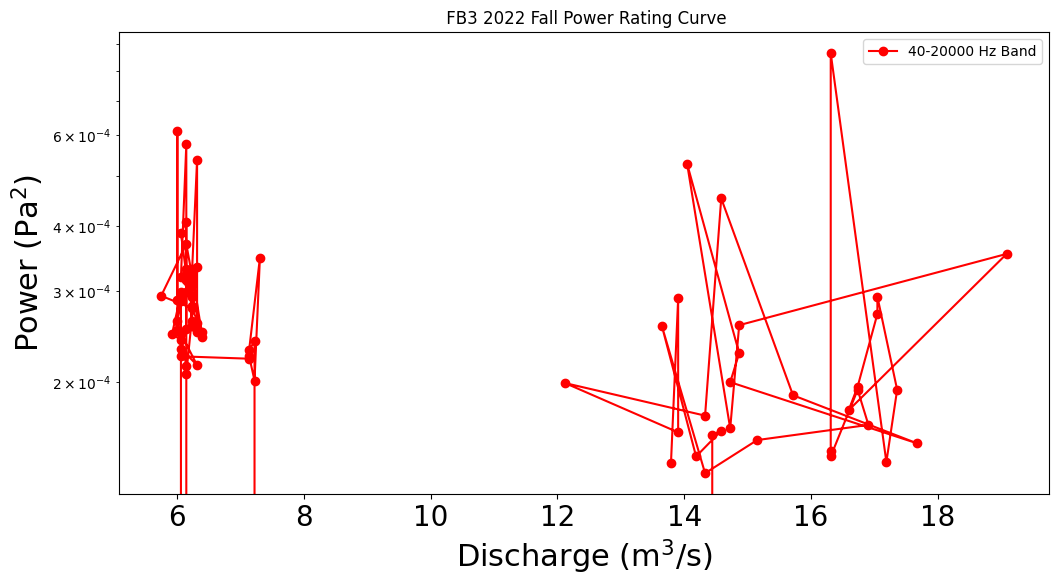

In [4]:
# plot discharge vs sound power
plt.figure(figsize = (12,6))
plt.title(station_name + ' Fall Power Rating Curve')

#plt.semilogy(Q_time, power_infrasound, 'b.-', markersize = 12, label = '5-40 Hz Band')
#plt.semilogy(Q_time, infra_power_band_limit[0], 'b--.', label = str(infra_freqs_low[0]) + '-' + str(infra_freqs_high[0]) + ' Hz Band' )
#plt.semilogy(Q_time, infra_power_band_limit[1], 'r--.', label = str(infra_freqs_low[1]) + '-' + str(infra_freqs_high[1]) + ' Hz Band' )
#plt.semilogy(times_infrasound, infra_power_band_limit[2], 'k--.', label = str(infra_freqs_low[2]) + '-' + str(infra_freqs_high[2]) + ' Hz Band' )

plt.semilogy(Q_time, power_audible, 'r.-', markersize = 12, label = '40-20000 Hz Band')
#plt.semilogy(Q_time, aud_power_band_limit[0], 'k.-.', label = str(aud_freqs_low[0]) + '-' + str(aud_freqs_high[0]) + ' Hz Band' )
# for y in infra_power_band_limit:
#     plt.semilogy(Q_time, y, 'r.-', markersize = 12, label = str(infra_freqs_low) + '-' + str(infra_freqs_high) + ' Hz Band')

plt.xlabel('Discharge (m$^3$/s)', fontsize = 22)
plt.ylabel('Power (Pa$^2$)', fontsize = 22)
plt.legend(fontsize = 10)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
# label points by date
indices = [-1,0,9,25,42,44,56,-5]
indices_general = [0, int(n_days/2), int(n_days/4), int(n_days*0.75), -1]
#power2_infrasound = [power_infrasound[z] for z in indices_general]
power2_audible = [power_audible[z] for z in indices_general]
times2_infrasound = pdtimes_infrasound
times2_infrasound = [times2_infrasound[z] for z in indices_general]
X = interp_times(times2_infrasound, t, q)

#Y = power2_infrasound
#Y = power2_audible

# for i, label in enumerate(times2_infrasound):
#     plt.text( X[i],Y[i],label.strftime('%b %d'), fontsize = 18, weight = "bold")
# power2_audible = [power_audible[z] for z in indices]
# times2_audible = pd.to_datetime(times_audible, format = '%d', dayfirst = True)
# times2_audible = [times2_audible[z] for z in indices]
# X2 = interp_times(times2_audible, t, q)
# Y2 = power2_audible
# for i, label in enumerate(times2_audible):
#     plt.text( X2[i],Y2[i],label.strftime('%m-%d')
# plot 1:1 relationship

/tmp/ipykernel_100757/3823185164.py:30: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(['Infrasound'], ['Audible'], fontsize = 16)
/tmp/ipykernel_100757/3823185164.py:46: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(['Infrasound'], ['Audible'], fontsize = 16)


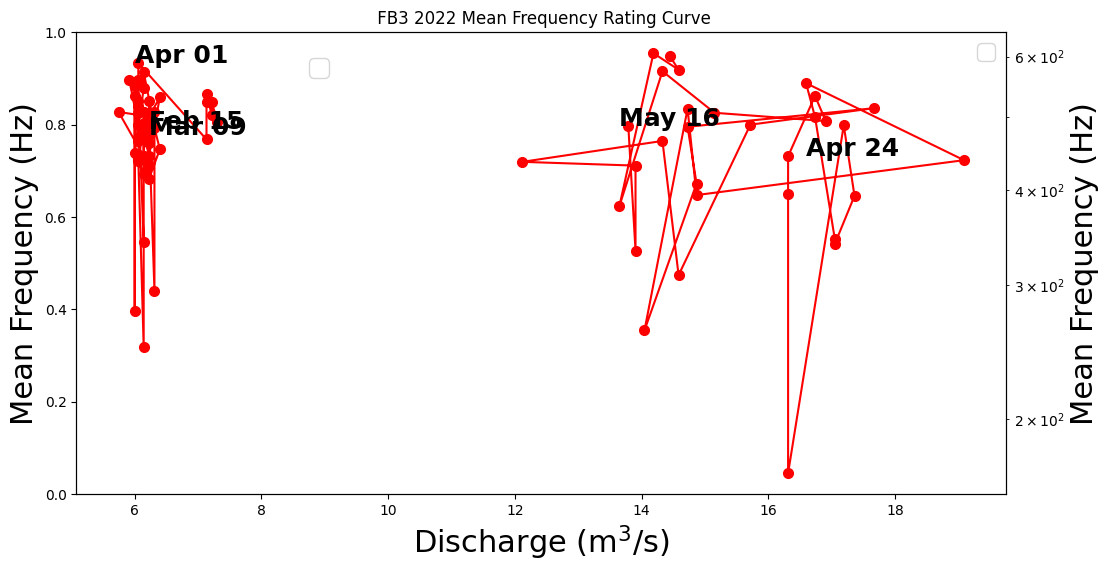

In [9]:
# plt.figure(figsize = (12,6)) 
# num_colors = len(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# for ii in range(n_days):
#     col = plt.rcParams['axes.prop_cycle'].by_key()['color'][ii%num_colors]
#     plt.loglog(X, Y[ii,:], color = col)
#     #plt.loglog(X2, Y2[ii,:], color = col, label = plot_times[ii].strftime('%m-%d'))
#     plt.legend() # uses labels from plt.loglog
#     #plt.xlabel('Frequency (Hz)')
#     #plt.ylabel('Power Spectral Density (counts$^2$/Hz)')
                 
## plot discharge vs infrasound and audible peak frequencies
fig, ax1 = plt.subplots(figsize = (12,6))
ax1.set_title(station_name + ' Mean Frequency Rating Curve')
ax1.set_xlabel('Discharge (m$^3$/s)', fontsize = 22)
ax1.set_ylabel('Mean Frequency (Hz)', fontsize = 22)
#ax1.semilogy(interp_times(times_infrasound, t, q), riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound), 'b.-', markersize = 14)
ax2 = ax1.twinx()
ax2.semilogy(interp_times(times_audible, t, q), riversound.find_mean_freq(meanspec_audible, freqs_audible), 'r.-', markersize = 14)
ax2.set_xlabel('Discharge (m$^3$/s)', fontsize = 22)
ax2.set_ylabel('Mean Frequency (Hz)', fontsize = 22)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax1.legend(['Infrasound'], fontsize = 18, loc= (0.25, 0.9))
ax2.legend(['Audible'], fontsize = 18, loc= (0.25, 0.8))

#mean_freq = riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound)
mean_freq2 = riversound.find_mean_freq(meanspec_audible, freqs_audible)
mean_freq2 = np.nan_to_num(mean_freq2, copy=True, nan=0.0, posinf=None, neginf=None)

plt.legend(['Infrasound'], ['Audible'], fontsize = 16)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
# indices = [-1,0,9,25,56] # turn on to evaluate separate indices
#meanfreq_infrasound = [mean_freq[z] for z in indices_general]
meanfreq_audible = [mean_freq2[z] for z in indices_general]
times2_infrasound = pdtimes_infrasound
times2_infrasound = [times2_infrasound[z] for z in indices_general]

X = interp_times(times2_infrasound, t, q)
#YY = meanfreq_infrasound
Y = meanfreq_audible 
for i, label in enumerate(times2_infrasound):
    plt.text( X[i],Y[i],label.strftime('%b %d'), fontsize = 18, weight = 'bold')
# for i, label in enumerate(times2_infrasound):
#     plt.text( X[i],YY[i],label.strftime('%b %d'), fontsize = 18, weight = 'bold')
plt.legend(['Infrasound'], ['Audible'], fontsize = 16)  

# meanfreq_audible = [mean_freq[z] for z in indices]
# times2_audible = pdtimes_infrasound
# times2_audible = [times2_audible[z] for z in indices]
# X = interp_times(times2_audible, t, q)
# Y = meanfreq_audible
# for i, label in enumerate(times2_audible):
#     plt.text( X[i],Y[i],label.strftime('%b %d'), fontsize = 18, weight = 'bold')

      ## plot the daily spectra
# plt.figure()
# num_colors = len(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# for i in range(n_days):
#     col = plt.rcParams['axes.prop_cycle'].by_key()['color'][i%num_colors]
#     plt.loglog(freqs_infrasound, meanspec_infrasound[i,:], color = col)
#     #plt.loglog(freqs_audible, meanspec_audible[i,:], color = col, label = plot_times[i].strftime('%Y-%m-%d'))
#     #plt.legend() # uses labels from plt.loglog
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Power Spectral Density (counts$^2$/Hz)')

In [10]:
import pickle
import os
print(os.getcwd()) # pickles are saved to cwd

Dictionary = {}
#Dictionary['power_infrasound_' + site + year + season] = power_infrasound
Dictionary['power_audible_' + site + year + season] = power_audible
#Dictionary['power_infrasound_nonzero_' + site + year + season] = power_infrasound_nonzero
#Dictionary['power_audible_nonzero_' + site + year + season] = power_audible_nonzero
#Dictionary['meanfreq_infra_' + site + year + season] = mean_freq
Dictionary['meanfreq_aud_' + site + year + season] = mean_freq2
#Dictionary['times_infra_' + site + year + season] = times_infrasound
Dictionary['times_aud_' + site + year + season] = times_audible

#Q_infra = interp_times(times_infrasound, t, q)
Q_aud = interp_times(times_audible, t, q)

#Dictionary['Q_infra_' + site + year + season] = Q_infra
Dictionary['Q_aud_' + site + year + season] = Q_aud
#Dictionary['Q_infra_nonzero_' + site + year + season] = Q_time_infra_index

#Dictionary['Q_aud_nonzero_' + site + year + season] = Q_time_aud
#Dictionary['aud_meanfreq_filtered_' + site + year + season] = aud_meanfreq_filtered

# pickle that shit
with open(site + year + season + '.pickle', 'wb') as handle:
    pickle.dump(Dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(site + year + season + '.pickle', 'rb') as handle:
    b = pickle.load(handle)

/home/scott/bender/gradschool/code/riversound/examples/Spring_2022_code/Boise_dams
